In [1]:
import math
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple
import os
import subprocess
from tqdm import trange
from copy import deepcopy

# from dirichlet_actor_critic import Policy
from env_two_step import Scenario, AMoD
from util import mat2str, dictsum, moving_average

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Dirichlet

plt.style.use('ggplot')
CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, x_ext, x_temp, action, reward, next_x_ext, next_x_temp, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (x_ext, x_temp, action, reward, next_x_ext, next_x_temp, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        x_ext, x_temp, action, reward, next_x_ext, next_x_temp, done = map(np.stack, zip(*batch))
        return x_ext, x_temp[:, 0], action, reward, next_x_ext, next_x_temp[:, 0], done
    
    def __len__(self):
        return len(self.buffer)

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Dirichlet

class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        
        # initialize affine transformations for neural net
        self.affine1 = nn.Linear(56+16+1, 128)
        self.affine2 = nn.Linear(128, 64)
        self.affine3 = nn.Linear(64, 64)
        
        # initialize GRU cell
        self.rnn = nn.GRU(input_size=56, hidden_size=32, batch_first=True)
        self.h_0 = nn.Parameter(torch.zeros(1, 1, 32))
        
        # actor's layer
        self.value_head = nn.Linear(96, 1)
        
    def forward(self, x_ext, x_temp):
        x_ext = F.relu(self.affine1(x_ext))
        x_ext = F.relu(self.affine2(x_ext))
        x_ext = F.relu(self.affine3(x_ext))
        
        _, x_temp = self.rnn(x_temp, self.h_0.repeat(1, x_temp.size(0), 1))
        
        h = torch.cat((x_ext.view(-1, 64), x_temp.view(-1, 32)), dim=1)
        x = self.value_head(h)
        return x
        
        
class SoftQNetwork(nn.Module):
    def __init__(self):
        super(SoftQNetwork, self).__init__()
        
        # initialize affine transformations for neural net
        self.affine1 = nn.Linear(56+16+1+8, 128)
        self.affine2 = nn.Linear(128, 64)
        self.affine3 = nn.Linear(64, 64)
        
        # initialize GRU cell
        self.rnn = nn.GRU(input_size=56, hidden_size=32, batch_first=True)
        self.h_0 = nn.Parameter(torch.zeros(1, 1, 32))
        
        # actor's layer
        self.q_head = nn.Linear(96, 1)
        
    def forward(self, x_ext, x_temp, action):
#         print("action: ", action.shape)
        x_ext = torch.cat([x_ext, action.view(x_ext.size(0), 8)], 1)
        x_ext = F.relu(self.affine1(x_ext))
        x_ext = F.relu(self.affine2(x_ext))
        x_ext = F.relu(self.affine3(x_ext))
        
        _, x_temp = self.rnn(x_temp, self.h_0.repeat(1, x_temp.size(0), 1))
        
        h = torch.cat((x_ext.view(-1, 64), x_temp.view(-1, 32)), dim=1)
        x = self.q_head(h)
        return x
        
        
class PolicyNetwork(nn.Module):
    def __init__(self, env):
        super(PolicyNetwork, self).__init__()
        self.env = env
        # initialize affine transformations for neural net
        self.affine1 = nn.Linear(56+16+1, 128)
        self.affine2 = nn.Linear(128, 64)
        self.affine3 = nn.Linear(64, 64)
        
        # initialize GRU cell
        self.rnn = nn.GRU(input_size=56, hidden_size=32, batch_first=True)
        self.h_0 = nn.Parameter(torch.zeros(1, 1, 32))
        
        # actor's layer
        self.action_head = nn.Linear(96, 8)
        
    def forward(self, x_ext, x_temp):
        """
        forward of both actor and critic
        """
        x_ext = F.relu(self.affine1(x_ext))
        x_ext = F.relu(self.affine2(x_ext))
        x_ext = F.relu(self.affine3(x_ext))
        
#         print(x_temp.shape)
        _, x_temp = self.rnn(x_temp, self.h_0.repeat(1, x_temp.size(0), 1))
        
        h = torch.cat((x_ext.view(-1, 64), x_temp.view(-1, 32)), dim=1)
        
        # actor: choses action to take from state s_t 
        # by returning probability of each action
        action_prob = F.softplus(self.action_head(h)).reshape(-1, 8) + 1e-20
        
        return action_prob
    
    def evaluate(self, x_ext, x_temp, epsilon=1e-6):
        concentrations = self.forward(x_ext, x_temp)
        print(concentrations.shape)
        m = Dirichlet(concentrations)

        # and sample an action using the distribution
        action = m.sample() + 1e-20
        
        log_prob = m.log_prob(action) #- torch.log(1 - action.pow(2) + epsilon)
        log_prob = log_prob.view(-1,1)#.sum(-1, keepdim=True)
        
        return action, log_prob, concentrations
        
    
    def get_action(self, state):
        concentrations = self.forward(state[0], state[1])
        
        m = Dirichlet(concentrations)

        # and sample an action using the distribution
        action = m.sample()
        return list(action[0].numpy())
    
    def get_available_vehicles(self):
        """
        Count total number of available vehicles.
        """
        return np.sum([self.env.acc[region][self.env.time] for region in self.env.region])
    
    def get_desired_distribution(self, action_rl):
        """
        Given a RL action, returns the desired number of vehicles in each area.
        """
        v_d = action_rl*self.get_available_vehicles()
        return list(v_d.numpy())

In [5]:
def soft_q_update(batch_size, 
           gamma=0.99,
           concentrations_lambda=1e-3,
           soft_tau=1e-2,
          ):
    x_ext, x_temp, action, reward, next_x_ext, next_x_temp, done = replay_buffer.sample(batch_size)

    x_ext      = torch.FloatTensor(x_ext).to(device)
    x_temp      = torch.FloatTensor(x_temp).to(device)
    next_x_ext = torch.FloatTensor(next_x_ext).to(device)
    next_x_temp = torch.FloatTensor(next_x_temp).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)
    
    expected_q_value1 = soft_q_net1(x_ext, x_temp, action)
    expected_q_value2 = soft_q_net2(x_ext, x_temp, action)
    expected_q_value = torch.min(expected_q_value1, expected_q_value2)
    print(f"Expected q value: {expected_q_value.mean()}, {expected_q_value.shape}")
    expected_value   = value_net(x_ext, x_temp)
    new_action, log_prob, concentrations = policy_net.evaluate(x_ext, x_temp)

    target_value = target_value_net(next_x_ext, next_x_temp)
    print(f"Target value: {target_value.mean()}, {target_value.shape}")
    next_q_value = reward + (1 - done) * gamma * (target_value)
    q_value_loss = soft_q_criterion(expected_q_value, next_q_value.detach())

    expected_new_q_value1 = soft_q_net1(x_ext, x_temp, new_action)
    expected_new_q_value2 = soft_q_net2(x_ext, x_temp, new_action)
    expected_new_q_value = torch.min(expected_new_q_value1, expected_new_q_value2)
    print(f"Expected new q: {expected_new_q_value.mean()}, {expected_new_q_value.shape}")
    next_value = expected_new_q_value - 0.1*log_prob
    value_loss = value_criterion(expected_value, next_value.detach())

    log_prob_target = expected_new_q_value - expected_value
    print(f"Log prob: {log_prob.mean()}, {log_prob.shape}")
#     policy_loss = (0.2*log_prob - expected_new_q_value).mean()
    policy_loss = (0.1*log_prob * (log_prob - log_prob_target).detach()).mean()
    

    concentrations_loss = concentrations_lambda * concentrations.pow(2).sum(1).mean()

    policy_loss += concentrations_loss

    soft_q_optimizer1.zero_grad()
    soft_q_optimizer2.zero_grad()
    q_value_loss.backward()
    soft_q_optimizer1.step()
    soft_q_optimizer2.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

In [6]:
# build scenario
scenario = Scenario(sd=10,demand_input = {(1,6):2, (0,7):2, 'default':0.1}, fix_price=True)
env = AMoD(scenario)

In [7]:
value_net        = ValueNetwork().to(device)
target_value_net = ValueNetwork().to(device)

soft_q_net1 = SoftQNetwork().to(device)
soft_q_net2 = SoftQNetwork().to(device)
policy_net = PolicyNetwork(env).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion = nn.MSELoss()

value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer1 = optim.Adam(soft_q_net1.parameters(), lr=soft_q_lr)
soft_q_optimizer2 = optim.Adam(soft_q_net2.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

### Train model from scratch

In [8]:
max_frames  = 40000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 256

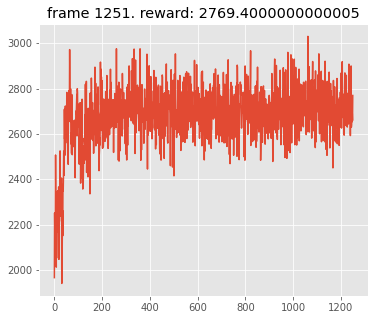

Episode 1251 | Reward: 2769.40 | Revenue: 3069.00 | ServedDemand: 354.00 | Reb. Cost: 95.00 | Oper. Cost: 299.60:   3%|▎         | 1251/50000 [12:11:04<420:40:04, 31.07s/it]

Expected q value: 1140.671630859375, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1106.851806640625, torch.Size([256, 1])
Expected new q: 1141.0377197265625, torch.Size([256, 1])
Log prob: 10.867460250854492, torch.Size([256, 1])
Expected q value: 1117.5914306640625, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1080.40478515625, torch.Size([256, 1])
Expected new q: 1117.931884765625, torch.Size([256, 1])
Log prob: 10.877243041992188, torch.Size([256, 1])
Expected q value: 1058.0504150390625, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1027.1337890625, torch.Size([256, 1])
Expected new q: 1058.2957763671875, torch.Size([256, 1])
Log prob: 10.893722534179688, torch.Size([256, 1])
Expected q value: 1101.0631103515625, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1069.62841796875, torch.Size([256, 1])
Expected new q: 1101.31298828125, torch.Size([256, 1])
Log prob: 10.798723220825195, torch.Size([256, 1])
Expected q value: 1165.551025390625, tor

Expected q value: 1108.916015625, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1071.323974609375, torch.Size([256, 1])
Expected new q: 1109.026123046875, torch.Size([256, 1])
Log prob: 10.801746368408203, torch.Size([256, 1])
Expected q value: 1067.491943359375, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1031.793212890625, torch.Size([256, 1])
Expected new q: 1068.0184326171875, torch.Size([256, 1])
Log prob: 10.956714630126953, torch.Size([256, 1])
Expected q value: 1137.168701171875, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1111.154296875, torch.Size([256, 1])
Expected new q: 1137.2593994140625, torch.Size([256, 1])
Log prob: 10.786877632141113, torch.Size([256, 1])
Expected q value: 1062.326904296875, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1030.9248046875, torch.Size([256, 1])
Expected new q: 1062.6363525390625, torch.Size([256, 1])
Log prob: 10.870406150817871, torch.Size([256, 1])
Expected q value: 1079.09521484375, torch.Siz

Episode 1252 | Reward: 2677.40 | Revenue: 2979.00 | ServedDemand: 331.00 | Reb. Cost: 103.00 | Oper. Cost: 301.60:   3%|▎         | 1252/50000 [12:11:35<421:31:55, 31.13s/it]

Expected q value: 1062.65185546875, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1028.5604248046875, torch.Size([256, 1])
Expected new q: 1062.7760009765625, torch.Size([256, 1])
Log prob: 10.615538597106934, torch.Size([256, 1])
Expected q value: 1126.522216796875, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1092.67578125, torch.Size([256, 1])
Expected new q: 1126.715087890625, torch.Size([256, 1])
Log prob: 10.81954574584961, torch.Size([256, 1])
Expected q value: 1051.766357421875, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1022.0250244140625, torch.Size([256, 1])
Expected new q: 1051.9534912109375, torch.Size([256, 1])
Log prob: 10.788832664489746, torch.Size([256, 1])
Expected q value: 1129.7679443359375, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1094.935791015625, torch.Size([256, 1])
Expected new q: 1129.9197998046875, torch.Size([256, 1])
Log prob: 10.919925689697266, torch.Size([256, 1])
Expected q value: 1045.28271484375, torc

Expected q value: 1116.05810546875, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1078.2763671875, torch.Size([256, 1])
Expected new q: 1116.5604248046875, torch.Size([256, 1])
Log prob: 10.95545768737793, torch.Size([256, 1])
Expected q value: 1062.230712890625, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1031.021484375, torch.Size([256, 1])
Expected new q: 1062.98291015625, torch.Size([256, 1])
Log prob: 11.178716659545898, torch.Size([256, 1])
Expected q value: 1116.844970703125, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1089.5338134765625, torch.Size([256, 1])
Expected new q: 1117.3450927734375, torch.Size([256, 1])
Log prob: 10.923730850219727, torch.Size([256, 1])
Expected q value: 1098.092529296875, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1067.114990234375, torch.Size([256, 1])
Expected new q: 1098.1016845703125, torch.Size([256, 1])
Log prob: 10.832681655883789, torch.Size([256, 1])
Expected q value: 1132.280517578125, torch.S

Episode 1253 | Reward: 2756.20 | Revenue: 3051.00 | ServedDemand: 347.00 | Reb. Cost: 91.40 | Oper. Cost: 294.80:   3%|▎         | 1253/50000 [12:12:06<421:06:42, 31.10s/it] 

Expected q value: 1108.29931640625, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1075.308349609375, torch.Size([256, 1])
Expected new q: 1108.7501220703125, torch.Size([256, 1])
Log prob: 10.75635814666748, torch.Size([256, 1])
Expected q value: 1124.646484375, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1094.37060546875, torch.Size([256, 1])
Expected new q: 1124.59423828125, torch.Size([256, 1])
Log prob: 10.784582138061523, torch.Size([256, 1])
Expected q value: 1134.9658203125, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1104.84912109375, torch.Size([256, 1])
Expected new q: 1134.9969482421875, torch.Size([256, 1])
Log prob: 10.696184158325195, torch.Size([256, 1])
Expected q value: 1070.799072265625, torch.Size([256, 1])
torch.Size([256, 8])
Target value: 1037.06494140625, torch.Size([256, 1])
Expected new q: 1071.1339111328125, torch.Size([256, 1])
Log prob: 10.850622177124023, torch.Size([256, 1])
Expected q value: 1094.68115234375, torch.Size([

OSError: [Errno 12] Cannot allocate memory

In [9]:
# book-keeping variables
training_rewards = []
training_revenue = []
training_served_demand = []
training_rebalancing_cost = []
training_operating_cost = []

# last_t_update = 0
train_episodes = 50000 # num_of_episodes_with_same_epsilon x num_of_q_tables x num_epsilons          
max_steps = 100 # maximum length of episode
epochs = trange(train_episodes) # build tqdm iterator for loop visualization

for i_episode in epochs:
    try:
        obs = env.reset()
        episode_reward = 0
        episode_revenue = 0
        episode_served_demand = 0
        episode_rebalancing_cost = 0
        episode_operating_cost = 0
        for step in range(max_steps):
            # take matching step 
            obs, paxreward, done, info = env.pax_step(CPLEXPATH=CPLEXPATH, PATH="SAC/v7/")
            episode_reward += paxreward
            # Select and perform an RL action
            x_ext = torch.tensor([obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                    [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            x_temp = torch.tensor([env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]).view(1, 10, 56).float()
            state = (x_ext, x_temp)
            action_rl = policy_net.get_action(state)

            # 1.2 get actual vehicle distributions vi (i.e. (x1*x2*..*xn)*num_vehicles)
            v_d = policy_net.get_desired_distribution(torch.tensor(action_rl))

            # 1.3 Solve ILP - Minimal Distance Problem 
            # 1.3.1 collect inputs and build .dat file
            t = env.time
            accTuple = [(n,int(env.acc[n][t])) for n in env.acc]
            accRLTuple = [(n, int(v_d_n)) for n, v_d_n in enumerate(v_d)]
            edgeAttr = [(i,j,env.G.edges[i,j]['time']) for i,j in env.G.edges]
            modPath = os.getcwd().replace('\\','/')+'/mod/'
            OPTPath = os.getcwd().replace('\\','/')+'/OPT/SAC/v7/'
            if not os.path.exists(OPTPath):
                os.makedirs(OPTPath)
            datafile = OPTPath + f'data_{t}.dat'
            resfile = OPTPath + f'res_{t}.dat'
            with open(datafile,'w') as file:
                file.write('path="'+resfile+'";\r\n')
                file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
                file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
                file.write('accRLTuple='+mat2str(accRLTuple)+';\r\n')

            # 2. execute .mod file and write result on file
            modfile = modPath+'minRebDistRebOnly.mod'
            if CPLEXPATH is None:
                CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
            my_env = os.environ.copy()
            my_env["LD_LIBRARY_PATH"] = CPLEXPATH
            out_file =  OPTPath + f'out_{t}.dat'
            with open(out_file,'w') as output_f:
                subprocess.check_call([CPLEXPATH+"oplrun", modfile, datafile], stdout=output_f, env=my_env)
            output_f.close()

            # 3. collect results from file
            flow = defaultdict(float)
            with open(resfile,'r', encoding="utf8") as file:
                for row in file:
                    item = row.strip().strip(';').split('=')
                    if item[0] == 'flow':
                        values = item[1].strip(')]').strip('[(').split(')(')
                        for v in values:
                            if len(v) == 0:
                                continue
                            i,j,f = v.split(',')
                            flow[int(i),int(j)] = float(f)
            rebAction = [flow[i,j] for i,j in env.edges]

            # Take step
            new_obs, rebreward, done, info = env.reb_step(rebAction)
            episode_reward += rebreward
            x_ext = torch.tensor([new_obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                    [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            x_temp = torch.tensor([env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]).view(1, 10, 56).float()
            new_state = (x_ext, x_temp)

            # Store the transition in memory
            replay_buffer.push(state[0].numpy(), state[1].numpy(), np.array(action_rl), paxreward + rebreward, new_state[0].numpy(), new_state[1].numpy(), done)
            
            if len(replay_buffer) > batch_size:
                soft_q_update(batch_size)
                
            # Move to the next state
            # track performance over episode
            episode_revenue += info['revenue']
            episode_served_demand += info['served_demand']
            episode_rebalancing_cost += info['rebalancing_cost']
            episode_operating_cost += info['operating_cost']
            obs, state = deepcopy(new_obs), deepcopy(new_state)
            
            
            if done:
                break
        
        epochs.set_description(f"Episode {i_episode+1} | Reward: {episode_reward:.2f} | Revenue: {episode_revenue:.2f} | ServedDemand: {episode_served_demand:.2f} \
| Reb. Cost: {episode_rebalancing_cost:.2f} | Oper. Cost: {episode_operating_cost:.2f}")
        #Adding the total reward and reduced epsilon values
        training_rewards.append(episode_reward)
        training_revenue.append(episode_revenue)
        training_served_demand.append(episode_served_demand)
        training_rebalancing_cost.append(episode_rebalancing_cost)
        training_operating_cost.append(episode_operating_cost)
        
        if i_episode % 5 == 0:
            plot(i_episode+1, training_rewards)
            
    except KeyboardInterrupt:
        break

In [1]:
# Plot results with moving average smoothing 
plt.style.use("seaborn-white")
fig = plt.figure(figsize=(12,32))
fig.add_subplot(411)
plt.plot(moving_average(training_rewards, n=10), label="Avg. Reward")
plt.title("Avg. Rewards")
plt.xlabel("Episode")
plt.ylabel("J")
plt.legend()

fig.add_subplot(412)
plt.plot(moving_average(training_revenue, n=10), label="Avg. Revenue")
plt.title("Avg. Revenue")
plt.xlabel("Episode")
plt.ylabel("Revenue")
plt.legend()

fig.add_subplot(413)
plt.plot(moving_average(training_served_demand, n=10), label="Avg. Served Demand")
plt.title("Avg. Served Demand")
plt.xlabel("Episode")
plt.ylabel("Served Demand")
plt.legend()

fig.add_subplot(414)
plt.plot(moving_average(training_rebalancing_cost, n=10), label="Avg. Reb. Cost")
plt.title("Avg. Reb. Cost")
plt.xlabel("Episode")
plt.ylabel("Cost")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

### Test

In [27]:
# three levels
scenario = Scenario(sd=10,demand_input = {(1,6):2, (0,7):2, 'default':0.1}, fix_price=True) # uni-directional
env = AMoD(scenario)
model.env = env

In [28]:
from tqdm import trange

test_episodes = 100
max_steps = 100
epochs = trange(test_episodes) # build tqdm iterator for loop visualization
np.random.seed(10)

test_rewards = []
test_revenue = []
test_served_demand = []
test_rebalancing_cost = []
test_operating_cost = []
action_list = []

for episode in epochs:
    try:
        episode_reward = 0
        episode_revenue = 0
        episode_served_demand = 0
        episode_rebalancing_cost = 0
        episode_operating_cost = 0
        episode_action_list = []
        obs = env.reset()
        done = False
        while(not done):
            # take matching step 
            obs, paxreward, done, info = env.pax_step(CPLEXPATH=CPLEXPATH, PATH="AC/v9/")
            episode_reward += paxreward
            # Select and perform an RL action
            x_ext = torch.tensor([obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                    [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            x_temp = torch.tensor([env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]).view(1, 10, 56).float()
            state = (x_ext, x_temp)
            with torch.no_grad():
                c, _ = model(state[0], state[1])
                action_rl = list(c.numpy()/c.numpy().sum())
            episode_action_list.append(action_rl)

            # 1.2 get actual vehicle distributions vi (i.e. (x1*x2*..*xn)*num_vehicles)
            v_d = model.get_desired_distribution(torch.tensor(action_rl))

            # 1.3 Solve ILP - Minimal Distance Problem 
            # 1.3.1 collect inputs and build .dat file
            t = env.time
            accTuple = [(n,int(env.acc[n][t])) for n in env.acc]
            accRLTuple = [(n, int(v_d_n)) for n, v_d_n in enumerate(v_d)]
            edgeAttr = [(i,j,env.G.edges[i,j]['time']) for i,j in env.G.edges]
            modPath = os.getcwd().replace('\\','/')+'/mod/'
            OPTPath = os.getcwd().replace('\\','/')+'/OPT/AC/v9/'
            if not os.path.exists(OPTPath):
                os.makedirs(OPTPath)
            datafile = OPTPath + f'data_{t}.dat'
            resfile = OPTPath + f'res_{t}.dat'
            with open(datafile,'w') as file:
                file.write('path="'+resfile+'";\r\n')
                file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
                file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
                file.write('accRLTuple='+mat2str(accRLTuple)+';\r\n')

            # 2. execute .mod file and write result on file
            modfile = modPath+'minRebDistRebOnly.mod'
            if CPLEXPATH is None:
                CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
            my_env = os.environ.copy()
            my_env["LD_LIBRARY_PATH"] = CPLEXPATH
            out_file =  OPTPath + f'out_{t}.dat'
            with open(out_file,'w') as output_f:
                subprocess.check_call([CPLEXPATH+"oplrun", modfile, datafile], stdout=output_f, env=my_env)
            output_f.close()

            # 3. collect results from file
            flow = defaultdict(float)
            with open(resfile,'r', encoding="utf8") as file:
                for row in file:
                    item = row.strip().strip(';').split('=')
                    if item[0] == 'flow':
                        values = item[1].strip(')]').strip('[(').split(')(')
                        for v in values:
                            if len(v) == 0:
                                continue
                            i,j,f = v.split(',')
                            flow[int(i),int(j)] = float(f)
            rebAction = [flow[i,j] for i,j in env.edges]

            new_obs, rebreward, done, info = env.reb_step(rebAction)
            episode_reward += rebreward
            x_ext = torch.tensor([new_obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                    [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            x_temp = torch.tensor([env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]).view(1, 10, 56).float()
            new_state = (x_ext, x_temp)
            
            episode_served_demand += info['served_demand']
            episode_rebalancing_cost += info['rebalancing_cost']
            episode_operating_cost += info['operating_cost']
            episode_revenue += info['revenue']
        epochs.set_description(f"Episode {episode+1} | Reward: {episode_reward:.2f} | Revenue: {episode_revenue:.2f} | ServedDemand: {episode_served_demand:.2f} \
| Reb. Cost: {episode_rebalancing_cost} | Oper. Cost: {episode_operating_cost:.2f}")
        #Adding the total reward and reduced epsilon values
        test_rewards.append(episode_reward)
        test_revenue.append(episode_revenue)
        test_served_demand.append(episode_served_demand)
        test_rebalancing_cost.append(episode_rebalancing_cost)
        test_operating_cost.append(episode_operating_cost)
        action_list.append(episode_action_list)
        break
    except KeyboardInterrupt:
        break





  0%|          | 0/100 [00:00<?, ?it/s]



Episode 1 | Reward: 2728.60 | Revenue: 3039.00 | ServedDemand: 318.00 | Reb. Cost: 107.8 | Oper. Cost: 310.40:   0%|          | 0/100 [00:05<?, ?it/s]